In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xml.etree.ElementTree as ET

### Quelle der Daten: 
https://www.bundestag.de/services/opendata

### Erläuterungen
WP steht für Wahlperiode

In [216]:
DATA_PATH = Path('data')
MDB_XML_PATH = DATA_PATH / 'MDB_STAMMDATEN.XML'
DF_MDB_PATH = DATA_PATH / 'df_mdb.csv' #one row per individuum, one col per wp containing 0 / 1
DF_MDB_WP_PATH = DATA_PATH / 'df_mdb_wp.csv' # one row per individuum per wp, containting e.g. 12. so one abgeordneter who has been in parliament for several wp will receive one row per wp

# parse xml data into dataFrame / .csv fomat

In [217]:
def get_mdb_data(mdb_xml_path = MDB_XML_PATH):
    """get data frame of MDP data
    ID | NACHNAME | VORNAME |  ... | BERUF"""
    list_of_mdb = []
    MDB_STAMMDATEN = ET.parse(mdb_xml_path)
    root = MDB_STAMMDATEN.getroot()
    
    for mdb in root.findall('MDB'):
        mdb_dict = {}
        ID, NAMEN, BIOGRAFISCHE_ANGABEN, WAHLPERIODEN = mdb[0], mdb[1], mdb[2], mdb[3]

        mdb_dict['ID'] = ID.text
        mdb_dict['NACHNAME'] = NAMEN.find('NAME').find('NACHNAME').text  
        mdb_dict['VORNAME'] = NAMEN.find('NAME').find('VORNAME').text  

        #print(mdb.tag, mdb.text, mdb.findall('NACHNAME'))
        for element in BIOGRAFISCHE_ANGABEN:
            mdb_dict[element.tag] = element.text

        mdb_dict['ANZ_WAHLPERIODEN'] = len(list(WAHLPERIODEN))

        for wahlperiode in WAHLPERIODEN:
            mdb_dict[int(wahlperiode.find('WP').text)] = 1

        list_of_mdb.append(mdb_dict)
    return pd.DataFrame(list_of_mdb)

In [218]:
def get_mdb_wp_data(df_mdb):
    """
    reformat
    peter | lustig | wp1 | wp2
    
    into
    peter | lustig | wp1
    peter | lustig | wp2
    """
    
    wps = [column for column in df_mdb.columns if isinstance(column, int)] # probably 1 to 19 or 20
    columns_to_keep = [column for column in df_mdb.columns if not isinstance(column, int)] # 'BERUF', 'VITA_KURZ' etc
    
    # should be 19 before 2021, 20 afterwards
    max_wp = max(wps)
    
    # this could be optimized but only runs once for about 2 Minutes
    new_entries = []
    for idx, row in df_mdb.iterrows():
        for wp in wps:
            if row[wp] == 1:
                new_entry = row[columns_to_keep]
                new_entry['WP'] = wp
                new_entries.append(new_entry)
    
    mdb_wp = pd.DataFrame(new_entries)
    return(mdb_wp)

In [219]:
df_mdb = get_mdb_data(MDB_XML_PATH)
print(df_mdb.shape)
df_mdb.head()

(4089, 34)


,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,2,12,13,14,15,16,1,17,18,19
0,11000001,Abelein,Manfred,20.10.1930,Stuttgart,None,17.01.2008,männlich,keine Angaben,katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11000002,Achenbach,Ernst,09.04.1909,Siegen,None,02.12.1991,männlich,"verheiratet, 3 Kinder",evangelisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11000003,Ackermann,Annemarie,26.05.1913,Parabutsch,Jugoslawien,18.02.1994,weiblich,"verheiratet, 5 Kinder",katholisch,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11000004,Ackermann,Else,06.11.1933,Berlin,None,14.09.2019,weiblich,ledig,evangelisch,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11000005,Adam,Ulrich,09.06.1950,"Teterow, Kr. Teterow, Bezirk Neubrandenburg",None,None,männlich,"verheiratet, 2 Kinder",evangelisch,...,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [220]:
df_mdb_wp = get_mdb_wp_data(df_mdb)

## Insight: es werden immer mehr Abgeordnete

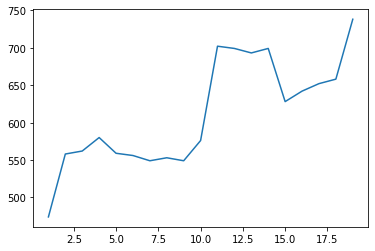

In [221]:
wps = [column for column in df_mdb.columns if isinstance(column, int)]
fig, ax = plt.subplots()#plt.figure(figsize=(8,6))

# xlab / ylab not showing is nb issue
plt.xlabel='WP'
plt.ylabel='Anzahl Abgeordneter'
#plt.plot(df_mdb[wps].sum().sort_index())
df_mdb[wps].sum().sort_index().plot()
plt.show()

In [222]:
df_mdb[wps].sum().sort_index().tail()

15    628.0
16    642.0
17    652.0
18    658.0
19    738.0
dtype: float64

In [223]:
# total number of abgeordnete (counting multiple wps as multiple entries)
df_mdb[wps].sum().sum()

11627.0

In [224]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(df_mdb_wp[df_mdb_wp.NACHNAME =='Baerbock'].iloc[0].VITA_KURZ)

('2000/04 Studium der Politikwissenschaft und Öffentliches Recht in Hamburg; '
 '2000/03 freie Mitarbeit bei der Hannoverschen Allgemeinen Zeitung; 2005 '
 'Master im Völkerrecht (LL.M.) an der LSE London; 2005/08 Büroleiterin der '
 'Europaabgeordneten Elisabeth Schroedter in Brüssel und Potsdam. 2008/09 '
 'Referentin für Außen- und Sicherheitspolitik bei der Grünen '
 'Bundestagsfraktion. 2009/13 Landesvors. BÜNDNIS 90/DIE GRÜNEN Brandenburg. '
 'Seit 2005 Mitgl. von Bündnis 90/Die Grünen, 2009/12 Mitgl. im Vorstand der '
 'Europäischen Grünen Partei; 2012/15 Mitgl. im Parteirat von Bündnis 90/Die '
 'Grünen, seit Jan. 2018 Bundesvors. von Bündnis90/Die Grünen. Englisch (f), '
 'Französisch (G), Spanisch (G). - MdB seit Okt. 2013.')


# clean data 1. missing values

In [225]:
dimensions_replace_na = ['NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT', 'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION', 'BERUF', 'PARTEI_KURZ']
df_mdb[dimensions_replace_na].isna().sum()

NACHNAME            0
VORNAME             0
GEBURTSDATUM        0
GEBURTSORT          4
GEBURTSLAND      4010
STERBEDATUM      2199
GESCHLECHT          0
FAMILIENSTAND      81
RELIGION          227
BERUF               3
PARTEI_KURZ         3
dtype: int64

In [226]:
df_mdb[dimensions_replace_na] = df_mdb[dimensions_replace_na].fillna('UNBEKANNT')

# 2. replace values: PARTEI_KURZ

In [227]:
df_mdb.PARTEI_KURZ.value_counts()[:12]

CDU                      1347
SPD                      1329
FDP                       460
CSU                       269
BÜNDNIS 90/DIE GRÜNEN     180
DIE LINKE.                128
AfD                        88
PDS                        54
GRÜNE                      51
DIE GRÜNEN/BÜNDNIS 90      28
DP                         27
FU                         21
Name: PARTEI_KURZ, dtype: int64

In [228]:
# some cleaning necessary: 'BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90' => 'GRÜNE'
for grünen_alias in ['BÜNDNIS 90/DIE GRÜNEN', 'DIE GRÜNEN/BÜNDNIS 90', 'GRÜNE']:
    df_mdb.replace(grünen_alias, 'DIE GRÜNEN', inplace=True)

# replace values: RELIGION

In [229]:
df_mdb.RELIGION.value_counts().head(12)

ohne Angaben              1214
evangelisch               1154
katholisch                 870
römisch-katholisch         316
UNBEKANNT                  227
evangelisch-lutherisch     138
konfessionslos             118
evangelisch-reformiert      15
religionslos                 7
Atheistin                    6
muslimisch                   5
freireligiös                 3
Name: RELIGION, dtype: int64

In [230]:
df_mdb['RELIGION_MAPPED'] = df_mdb.RELIGION

In [231]:
for katholisch_alias in ['römisch-katholisch', 'alt-katholisch']:
    df_mdb['RELIGION_MAPPED'].replace(katholisch_alias, 'katholisch', inplace=True)

In [232]:
for evangelisch_alias in ['evangelisch-lutherisch', 'evangelisch-reformiert', 'evangelisch-freikirchlich', 'protestantisch']:
    df_mdb['RELIGION_MAPPED'].replace(evangelisch_alias, 'evangelisch', inplace=True)

In [233]:
# it's not the same but its similar
for konfessionslos_alias in ['religionslos', 'Atheist', 'Atheistin']:
    df_mdb['RELIGION_MAPPED'].replace(konfessionslos_alias, 'konfessionslos', inplace=True)

In [234]:
for konfessionslos_alias in ['Islam']:
    df_mdb['RELIGION_MAPPED'].replace(konfessionslos_alias, 'muslimisch', inplace=True)

In [235]:
# erkenntnis: nur christen und einige wenige konfessionslose
df_mdb['RELIGION_MAPPED'].value_counts().head(24)

evangelisch            1311
ohne Angaben           1214
katholisch             1187
UNBEKANNT               227
konfessionslos          133
muslimisch                8
freireligiös              3
orthodox                  1
griechisch-orthodox       1
alevitisch                1
russisch-orthodox         1
humanistisch              1
neuapostolisch            1
Name: RELIGION_MAPPED, dtype: int64

<AxesSubplot:>

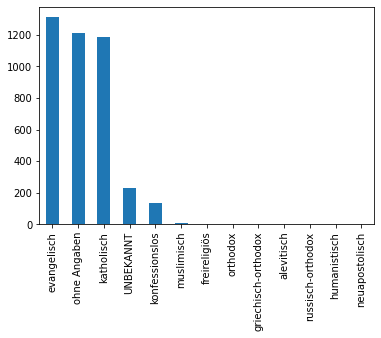

In [236]:
df_mdb['RELIGION_MAPPED'].value_counts().plot(kind='bar')

# replace values: BERUFE

In [430]:
# number of different jobs: 2k
len(set(df_mdb.BERUF))

2201

In [431]:
df_mdb['BERUF_MAPPED'] = df_mdb['BERUF'].copy()

In [432]:
df_mdb[['ID', 'BERUF']].groupby('BERUF').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF,
Rechtsanwalt,182
Geschäftsführer,80
Landwirt,79
Angestellter,63
Rechtsanwalt und Notar,47
Kaufmann,45
Journalist,43
Hausfrau,41


In [433]:
from importlib import reload
import berufe_mapping 
reload(berufe_mapping)
from berufe_mapping import basic_cleaning_berufe

'''very basic cleaning: lowercasing, removing dipl., (fh) and a.d.'''
df_mdb = basic_cleaning_berufe(df_mdb , column = 'BERUF_MAPPED')

In [434]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False).head(8)

,ID
BERUF_MAPPED,
rechtsanwalt,373
geschäftsführer,111
landwirt,105
-ingenieur,101
-volkswirt,82
lehrer,75
jurist,73
angestellter,73


In [435]:
re.sub('regierungs(vize)*präs', 'XX', 'abc regierungspräsident xjsk regierungsvizepräsidentin')

'abc XXident xjsk XXidentin'

In [490]:
dict_berufe={}
dict_berufe['Jurist*in'] = ['anwalt', 'jurist', 'richter', 'notar', re.compile('dr.*\s*jur.*'), 'syndikus', 'rechtsberater']
dict_berufe['Land-/Forstwirt*in'] = ['landwirt', '^[a-z]bauer\s', re.compile('agrar+'), 'forst']
dict_berufe['Unterehmer*in'] = ['unternehmer'] # geschäftsführer geht leider nicht wegen z.B. Parl. Geschäftssführer
dict_berufe['Ingenieur*in'] = ['ingenieur', 'maschinenbau']
dict_berufe['Journalist*in'] = ['journalist', 'redakteur', 'publizist', 'schriftsteller']
dict_berufe['Verleger*in'] = ['verleger', 'verlags']

# direktor: nö, sonst bezirksdirektor museumsdirektor etc
dict_berufe['Lehrer*in'] = ['erzieher', 'pädagog', 'lehrer', 'studienrat', 'studiendirektor',
                            'grundschul', 'hauptshul', 'sonderschul', 'waldorf', 'realschul', 'gymnasi',
                            'volkshochschu', 'berufsschul', 'fremdsprachen',
                           'schul'] #evtl trennen Erzieher - Lehrer
dict_berufe['Professor*in'] = ['dozent', 'professor', 'prof.', 'hochschull', 'hochschulpr']
dict_berufe['Kaufmann/-frau'] = ['kaufm']
dict_berufe['Volkswirt*in'] = ['volkswirt']
dict_berufe['Berufspolitiker*in'] = ['regierungsangestellt', 'stadtamtmann', 'stadtoberinspektor', 'Landesgeschäftsführer',
                                    'landr(at|ätin)', re.compile('ministerialr(a|ä)t'), 'staatssekret', 'bürgermeist', 
                                     'regierungsrat', re.compile('regierungs(vize)*präs'), 'regierung',
                                     'stadtdirektor', 'ministerialdirektor', 'regierungsdirektor', 'gemeindedirektor', 'regierungsdirektor',
                                     'minister', 'bundeskanz', 'bundestagsp', re.compile('präsident(in)* d\.*b\.*t\.*')]
dict_berufe['Arzt/Ärztin'] = ['arzt', 'psycholog', 'psychother', 'apotheker']
dict_berufe['Theolog*in'] = ['pfarrer', 'theolog', 'diakon']
dict_berufe['Betriebswirt*in'] = ['betriebswirt', 'verwaltungs', 'steuerberater', 'bankdirektor']
dict_berufe['Wirtschaftswissenschaftler*in'] = ['wirtschaftsw', 'ökonom', 'prokurist']
dict_berufe['Geisteswissenschaftler*in'] = ['politolog', 'politikwiss', 'historik', 'philosoph', 'philolog', 'soziolog', 'sozialwissensch', 'kulturwissenschaft']
dict_berufe['Naturwissenschaftler*in'] = ['chemik', 'chemie', 'physik', 'geophysik', 'biolog', 'mathemat', 'informat']

dict_berufe['Handwerker*in'] = ['elektro', 'fahrzeug', 'handwerk', 'mechanik',
                               'schlosser', 'maurer', 'beton', 'maler', 'lackier', 'tischler', 'schreiner',
                               'bäcker', 'konditor' 'koch', 'köchin', 'müller', 'bergmann', 'werkzeugmacher']

In [491]:
def replace_berufsklasse(berufsklasse = 'Jurist*in', dict_berufe = dict_berufe, df = df_mdb):
    values_to_replace = set()
    # TODO without loop but use 'any'
    for indikator in dict_berufe[berufsklasse]:
        values_to_replace = values_to_replace.union(set(df_mdb[df_mdb.BERUF_MAPPED.str.contains(indikator)].BERUF_MAPPED))

    print(values_to_replace)
    df_mdb.replace(list(values_to_replace), berufsklasse, inplace=True)
    return(df_mdb)

In [492]:
df_mdb = replace_berufsklasse(berufsklasse = 'Jurist*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [493]:
df_mdb = replace_berufsklasse(berufsklasse = 'Land-/Forstwirt*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [494]:
df_mdb = replace_berufsklasse(berufsklasse = 'Unterehmer*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [495]:
df_mdb = replace_berufsklasse(berufsklasse = 'Ingenieur*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [496]:
len(set(df_mdb.BERUF_MAPPED))

620

In [497]:
df_mdb = replace_berufsklasse(berufsklasse = 'Journalist*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [498]:
df_mdb = replace_berufsklasse(berufsklasse = 'Lehrer*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [499]:
df_mdb = replace_berufsklasse(berufsklasse = 'Kaufmann/-frau', dict_berufe = dict_berufe, df = df_mdb)

set()


In [500]:
df_mdb = replace_berufsklasse(berufsklasse = 'Professor*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [501]:
len(set(df_mdb.BERUF_MAPPED))

620

In [502]:
df_mdb = replace_berufsklasse(berufsklasse = 'Volkswirt*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [503]:
df_mdb = replace_berufsklasse(berufsklasse = 'Berufspolitiker*in', dict_berufe = dict_berufe, df = df_mdb)

set()


/usr/local/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [504]:
df_mdb = replace_berufsklasse(berufsklasse = 'Arzt/Ärztin', dict_berufe = dict_berufe, df = df_mdb)

set()


In [505]:
df_mdb = replace_berufsklasse(berufsklasse = 'Theolog*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [506]:
df_mdb = replace_berufsklasse(berufsklasse = 'Betriebswirt*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [507]:
df_mdb = replace_berufsklasse(berufsklasse = 'Wirtschaftswissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [508]:
df_mdb = replace_berufsklasse(berufsklasse = 'Geisteswissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'kulturwissenschaftler'}


In [509]:
df_mdb = replace_berufsklasse(berufsklasse = 'Naturwissenschaftler*in', dict_berufe = dict_berufe, df = df_mdb)

{'chemiefacharbeiter', 'chemielaborant'}


In [510]:
df_mdb = replace_berufsklasse(berufsklasse = 'Verleger*in', dict_berufe = dict_berufe, df = df_mdb)

set()


In [511]:
df_mdb = replace_berufsklasse(berufsklasse = 'Handwerker*in', dict_berufe = dict_berufe, df = df_mdb)

{'meister im maurer-', 'maurer'}


In [512]:
len(set(df_mdb.BERUF_MAPPED))

615

In [513]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False)[48:56]

,ID
BERUF_MAPPED,
selbständig,4
senator,4
abteilungsleiter,4
rektorin,4
oberkreisdirektor,4
wiss. mitarbeiter,4
sttoberinspektor,4
landesgeschäftsführer,4


In [514]:
df_mdb[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False)[:16]

,ID
BERUF_MAPPED,
Jurist*in,537
Berufspolitiker*in,326
Lehrer*in,311
Kaufmann/-frau,270
Land-/Forstwirt*in,193
Ingenieur*in,178
Journalist*in,143
Betriebswirt*in,136
Geisteswissenschaftler*in,124


<AxesSubplot:xlabel='BERUF_MAPPED'>

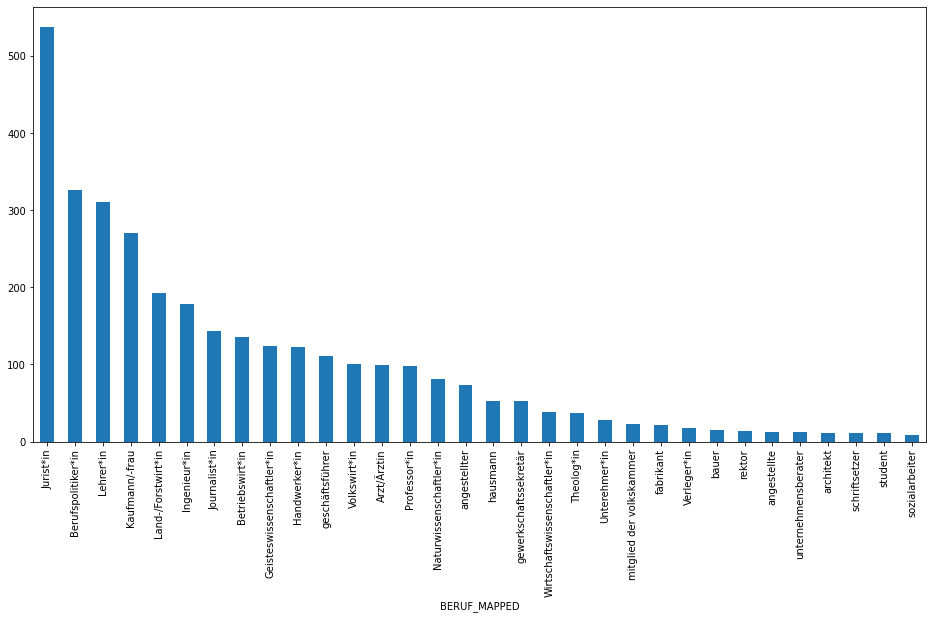

In [515]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
df_mdb.groupby('BERUF_MAPPED')['ID'].count().sort_values(ascending=False)[:32].plot(kind='bar')

In [516]:
len(set(df_mdb['BERUF_MAPPED']))

615

# construct df_mdb_wp

In [517]:
df_mdb_wp = get_mdb_wp_data(df_mdb)
print(df_mdb_wp.shape)

(11627, 18)


In [518]:
df_mdb_wp[df_mdb_wp.NACHNAME == 'Merkel'].head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,RELIGION_MAPPED,BERUF_MAPPED,WP
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,Berufspolitiker*in,12
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,Berufspolitiker*in,13
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,Berufspolitiker*in,14
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,Berufspolitiker*in,15
1465,11001478,Merkel,Angela,17.07.1954,Hamburg,UNBEKANNT,UNBEKANNT,weiblich,verheiratet,evangelisch,"Bundeskanzlerin, Dipl.-Physikerin",CDU,1973 Abitur in Templin. Physikstudium Univ. Le...,4 Funktionen in Körperschaften und Anstalten d...,8,evangelisch,Berufspolitiker*in,16


# save as csv

In [519]:
df_mdb.to_csv(DF_MDB_PATH, index=None)
df_mdb_wp.to_csv(DF_MDB_WP_PATH, index=None)

# read in data. exploratory data analysis

In [520]:
df_mdb = pd.read_csv(DF_MDB_PATH, index_col=None)
df_mdb_wp = pd.read_csv(DF_MDB_WP_PATH, index_col=None)

In [521]:
df_mdb.columns

Index(['ID', 'NACHNAME', 'VORNAME', 'GEBURTSDATUM', 'GEBURTSORT',
       'GEBURTSLAND', 'STERBEDATUM', 'GESCHLECHT', 'FAMILIENSTAND', 'RELIGION',
       'BERUF', 'PARTEI_KURZ', 'VITA_KURZ', 'VEROEFFENTLICHUNGSPFLICHTIGES',
       'ANZ_WAHLPERIODEN', '5', '6', '7', '8', '9', '10', '11', '3', '4', '2',
       '12', '13', '14', '15', '16', '1', '17', '18', '19', 'RELIGION_MAPPED',
       'BERUF_MAPPED'],
      dtype='object')

In [522]:
df_mdb.tail()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,...,13,14,15,16,1,17,18,19,RELIGION_MAPPED,BERUF_MAPPED
4084,11004958,Nölke,Matthias,08.01.1980,Kassel,UNBEKANNT,UNBEKANNT,männlich,ledig,konfessionslos,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,konfessionslos,Jurist*in
4085,11004959,Martin,Dorothee,21.01.1978,UNBEKANNT,UNBEKANNT,UNBEKANNT,weiblich,UNBEKANNT,UNBEKANNT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,UNBEKANNT,selbstständige kommunikationsberater
4086,11004960,Wetzel,Wolfgang,11.05.1968,Schlema,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",römisch-katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,katholisch,Lehrer*in
4087,11004961,Natterer,Christian,19.02.1981,Tettnang / Deutschland,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 1 Kind",römisch-katholisch,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,katholisch,Kaufmann/-frau
4088,11004962,Dahmen,Janosch,06.09.1981,UNBEKANNT,UNBEKANNT,UNBEKANNT,männlich,UNBEKANNT,UNBEKANNT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,UNBEKANNT,Arzt/Ärztin


In [523]:
df_mdb_wp[['ID', 'WP']].groupby('WP').count().sort_values(by='WP', ascending=False).head()

,ID
WP,
19,738
18,658
17,652
16,642
15,628


In [524]:
df_mdb_wp[['ID', 'PARTEI_KURZ']].groupby('PARTEI_KURZ').count().sort_values(by='ID', ascending=False).head(10)

,ID
PARTEI_KURZ,
SPD,4250
CDU,4150
FDP,1036
CSU,993
DIE GRÜNEN,536
DIE LINKE.,297
AfD,90
PDS,77
Plos,41


In [525]:
# wie - nur 2 Geschlechter? for the records: heute ist der 02.05.2021
df_mdb_wp[['ID', 'GESCHLECHT']].groupby('GESCHLECHT').count().sort_values(by='ID', ascending=False).head()

,ID
GESCHLECHT,
männlich,9382
weiblich,2245


In [526]:
# auch hier: such diversity. wow
df_mdb_wp[['ID', 'RELIGION']].groupby('RELIGION').count().sort_values(by='ID', ascending=False).head(n=16)

,ID
RELIGION,
evangelisch,3406
ohne Angaben,3275
katholisch,2985
römisch-katholisch,831
UNBEKANNT,428
evangelisch-lutherisch,366
konfessionslos,234
evangelisch-reformiert,34
Atheistin,12


In [527]:
# jetzt wirds richtig vielseitig. so viele Busfahrer und Krankenschwestern!
df_mdb_wp[['ID', 'BERUF']].groupby('BERUF').count().sort_values(by='ID', ascending=False).head(16).head(16)

,ID
BERUF,
Rechtsanwalt,567
Geschäftsführer,223
Landwirt,212
Angestellter,190
Rechtsanwalt und Notar,126
Journalist,117
Dipl.-Ingenieur,109
Kaufmann,104
Jurist,102


In [528]:
# jetzt wirds richtig vielseitig. so viele Busfahrer und Krankenschwestern!
df_mdb_wp[['ID', 'BERUF_MAPPED']].groupby('BERUF_MAPPED').count().sort_values(by='ID', ascending=False).head(16).head(16)

,ID
BERUF_MAPPED,
Jurist*in,1698
Berufspolitiker*in,1243
Lehrer*in,887
Kaufmann/-frau,693
Land-/Forstwirt*in,539
Ingenieur*in,516
Journalist*in,424
Betriebswirt*in,411
Handwerker*in,365


In [529]:
# gehen sie weiter. hier gibt es kein Klischee zu erkennen!
df_mdb_wp[['ID', 'FAMILIENSTAND']].groupby('FAMILIENSTAND').count().sort_values(by='ID', ascending=False).head(16)

,ID
FAMILIENSTAND,
"verheiratet, 2 Kinder",2726
"verheiratet, 3 Kinder",1816
verheiratet,1720
"verheiratet, 1 Kind",1365
keine Angaben,1043
"verheiratet, 4 Kinder",891
ledig,424
"verheiratet, 5 Kinder",329
"verheiratet, 6 Kinder",178


In [530]:
# deleteme
start_date=16
end_date=18
#wps = range(start_date, end_date)
#selected_df = pd.concat([df_mdb[df_mdb[str(i)] == 1] for i in range(start_date,end_date+1)]).drop_duplicates()# deleteme
selected_df = df_mdb_wp[(df_mdb_wp['WP']>= start_date) & (df_mdb_wp['WP']<= end_date)].sort_values(by='VEROEFFENTLICHUNGSPFLICHTIGES')
selected_df.head()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,RELIGION_MAPPED,BERUF_MAPPED,WP
11306,11004450,Zech,Tobias,09.07.1981,Trostberg,UNBEKANNT,UNBEKANNT,männlich,"verheiratet, 2 Kinder",römisch-katholisch,Geschäftsführer,CSU,1994/98 Wirtschaftsschule Mühldorf. 1998/2000 ...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,katholisch,geschäftsführer,18
10950,11004229,Reinhold,Hagen,23.03.1978,Wismar,UNBEKANNT,UNBEKANNT,männlich,3 Kinder,konfessionslos,Meister im Maurer- und Betonbauerhandwerk,FDP,"1994/97 Ausbildung zum Maurer und Betonbauer, ...",1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,konfessionslos,Handwerker*in,17
10491,11004004,Aumer,Peter,17.04.1976,Regensburg,UNBEKANNT,UNBEKANNT,männlich,ledig,römisch-katholisch,Dipl.-Betriebswirt (FH),CSU,Berufsausbildung zum Steuerfachgehilfen. Studi...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,katholisch,Betriebswirt*in,17
10886,11004179,Vogel,Johannes,29.04.1982,Wermelskirchen,UNBEKANNT,UNBEKANNT,männlich,verheiratet,evangelisch,Politikwissenschaftler,FDP,2001 Abitur am Städtischen Gymnasium Wermelski...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,evangelisch,Geisteswissenschaftler*in,17
11171,11004371,Paschke,Markus,08.06.1963,Bremen,UNBEKANNT,UNBEKANNT,männlich,verheiratet,ohne Angaben,Gewerkschaftssekretär,SPD,Gymnasium in Bremen. 1980/83 Ausbildung zum In...,1 Berufliche Tätigkeit vor der Mitgliedschaft ...,2,ohne Angaben,gewerkschaftssekretär,18


In [531]:
# deleteme BEGIN

In [111]:
df_mdb_wp.shape

(11627, 17)

In [112]:
import logging
def replace_sonstige(df_mdb, df_mdb_wp, dimension='PARTEI_KURZ', num_keep = 7):
    """
    keep num_keep most occurences, replace other values by "sonstige"
    """
    
    # e.g. 'CDU', 'SPD'
    values_to_keep = list(df_mdb_wp[['ID', dimension]].groupby(dimension).count().sort_values(by='ID', ascending=False)[:num_keep].index)
    values_to_discard = list(df_mdb[['ID', dimension]].groupby(dimension).count().sort_values(by='ID', ascending=False)[num_keep:].index)
    
    logging.info(f'[{dimension}]. keeping {values_to_keep}. replacing {values_to_discard[:4]} ... with <sonstige>')
    df_mdb[dimension].replace(values_to_discard, 'sonstige', inplace=True)
    df_mdb_wp[dimension].replace(values_to_discard, 'sonstige', inplace=True)
    
    return values_to_keep, values_to_discard, df_mdb, df_mdb_wp

list_of_parteien, list_of_parteien_discard, df_mdb, df_mdb_wp = replace_sonstige(df_mdb, df_mdb_wp, dimension='PARTEI_KURZ', num_keep = 8)
list_of_religion, list_of_religion_discard, df_mdb, df_mdb_wp = replace_sonstige(df_mdb, df_mdb_wp, dimension='RELIGION', num_keep = 6) 
list_of_familienstand, list_of_familienstand_discard, df_mdb, df_mdb_wp = replace_sonstige(df_mdb, df_mdb_wp, dimension='FAMILIENSTAND', num_keep = 8)
list_of_beruf, list_of_beruf_discard, df_mdb, df_mdb_wp = replace_sonstige(df_mdb, df_mdb_wp, dimension='BERUF_MAPPED', num_keep = 12)

# append 'sonstige' to list of valid values
for list_of_values in [list_of_parteien, list_of_religion, list_of_familienstand, list_of_beruf]:
    list_of_values += ['sonstige']

In [113]:
df_mdb_wp[['ID', 'PARTEI_KURZ']].groupby('PARTEI_KURZ').count().iloc[0]
print(df_mdb_wp.shape)

(11627, 17)


In [131]:
# deleteme START

In [142]:
start_date = 1
end_date = 19
df_mdb_wp[df_mdb_wp.PARTEI_KURZ == 'AfD'].groupby('WP').count()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,GESCHLECHT,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,BERUF_MAPPED
WP,,,,,,,,,,,,,,,,
14,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
15,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
19,88,88,88,88,88,88,88,88,88,88,88,88,88,83,88,88


In [135]:
df_mdb_wp[df_mdb_wp.PARTEI_KURZ=='AfD'].groupby('GESCHLECHT').count()

,ID,NACHNAME,VORNAME,GEBURTSDATUM,GEBURTSORT,GEBURTSLAND,STERBEDATUM,FAMILIENSTAND,RELIGION,BERUF,PARTEI_KURZ,VITA_KURZ,VEROEFFENTLICHUNGSPFLICHTIGES,ANZ_WAHLPERIODEN,BERUF_MAPPED,WP
GESCHLECHT,,,,,,,,,,,,,,,,
männlich,81,81,81,81,81,81,81,81,81,81,81,81,77,81,81,81
weiblich,9,9,9,9,9,9,9,9,9,9,9,9,8,9,9,9


In [116]:
logging.getLogger().setLevel(logging.INFO)

dimension = 'PARTEI_KURZ'
logging.info(f'+++++ starting evaluation of {dimension}')
logging.info(f'1. before selecting:{dimension} {df_mdb_wp.shape[0]}')


selected_df = df_mdb_wp[(df_mdb_wp['WP']>= start_date) & (df_mdb_wp['WP']<= end_date)]
logging.info(f'2. after selecting wp: {dimension} {selected_df.shape[0]}')

INFO:root:+++++ starting evaluation of PARTEI_KURZ
INFO:root:1. before selecting:PARTEI_KURZ 11627
INFO:root:2. after selecting wp: PARTEI_KURZ 11627


In [122]:
selected_df[selected_df.PARTEI_KURZ == 'AfD'].shape

(90, 17)

In [128]:
selected_parteien = ['AfD']
selected_berufe = list_of_beruf

In [129]:
selected_df_1 = selected_df[selected_df['PARTEI_KURZ'].isin(selected_parteien)]
logging.info(f'3. after selecting party: {selected_df_1.shape[0]}')
selected_df[selected_df.PARTEI_KURZ == 'AfD'].shape

INFO:root:3. after selecting party: 90


(90, 17)

In [130]:
# select berufe
selected_df = selected_df[selected_df['BERUF_MAPPED'].isin(selected_berufe)]
logging.info(selected_berufe)
logging.info(f'4. after selecting beruf: {selected_df.shape[0]}')
selected_df[selected_df.PARTEI_KURZ == 'AfD'].shape

INFO:root:['Jurist*in', 'Lehrer*in / Rektor*in [a. D.]', 'Berufspolitiker', 'Kaufmann/-frau', 'Land-/Forstwirt*in', 'Ingenieur*in', 'Geschäftsführer*in/Unternehmer*in', 'Angestellt[e] / Beamter*in', 'Betriebswirt*in / Verwaltungsangestellte*r', 'Handwerker*in', 'Volkswirtin*in', 'Geisteswissenschaftler*in', 'sonstige']
INFO:root:4. after selecting beruf: 11627


(90, 17)

In [ ]:
# deleteme END

In [ ]:
# deleteme
# keep occurences
NUM_DIM_KEEP = 8
values_to_keep = selected_df[['ID', 'FAMILIENSTAND']].groupby('FAMILIENSTAND').count().sort_values(by='ID', ascending=False).index[NUM_DIM_KEEP:2*NUM_DIM_KEEP]
values_to_keep

In [ ]:
levels = [values_to_keep, range(start_date, end_date+1)]
levels

In [ ]:
new_index = pd.MultiIndex.from_product(levels, names=['FAMILIENSTAND', 'WP'])
new_index

In [ ]:
# deleteme
grouped = selected_df[['ID', 'WP', 'FAMILIENSTAND']].groupby(['FAMILIENSTAND', 'WP']).count()
grouped.head(16)

In [ ]:
grouped = grouped.reindex(new_index, fill_value=0)
grouped

In [ ]:
grouped.reset_index(inplace=True)
grouped

In [ ]:
# deleteme
wps = sorted(list(set(grouped.WP)))
familienstands = list(set(grouped.FAMILIENSTAND))
traces_values = []


In [ ]:
for familienstand in familienstands:
    trace = grouped[grouped['FAMILIENSTAND'] == familienstand].sort_values(by='WP').ID.values
    traces_values.append(trace)
traces_values

# quality checks

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==19) & (df_mdb_wp.PARTEI_KURZ == 'CDU')]

In [ ]:
df_mdb_wp[(df_mdb_wp.WP==18) & (df_mdb_wp.PARTEI_KURZ == 'CDU') & (df_mdb_wp.BERUF.str.contains('Bürgermeister'))]